<a href="https://colab.research.google.com/github/weilainicolas/Deep-Learning/blob/master/L6_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *

In [0]:
bs=64

In [0]:
path=untar_data(URLs.PETS)/'images'

In [0]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,max_lighting=0.4,max_warp=0.4,
                    p_affine=1.,p_lighting=1.)

```to create a databunch,
 1 get the source data: a list of images. 
 2 split to train and valid here we random. 
 3 how to find the label 
 4 transform 
 5 convert to databunch ( databunch has data loader and ds defined)


In [0]:
src=ImageList.from_folder(path).split_by_rand_pct(0.2,seed=2)

In [0]:
def get_data(size,bs,padding_mode='reflection'):
  return(src.label_from_re(r'([^/]+)_\d+.jpg$')
        .transform(tfms,size=size,padding_mode=padding_mode)
        .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data=get_data(224,bs,'zeros')

In [0]:
def _plt (i,j,ax):
  x,y = data.train_ds[3]
  x.show(ax,y=y)

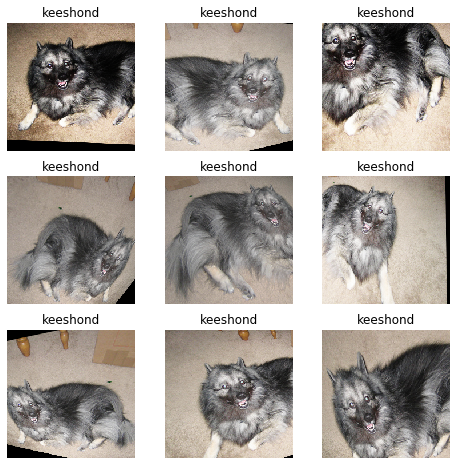

In [0]:
plot_multi(_plt,3,3,figsize=(8,8))

In [0]:
data=get_data(224,bs)

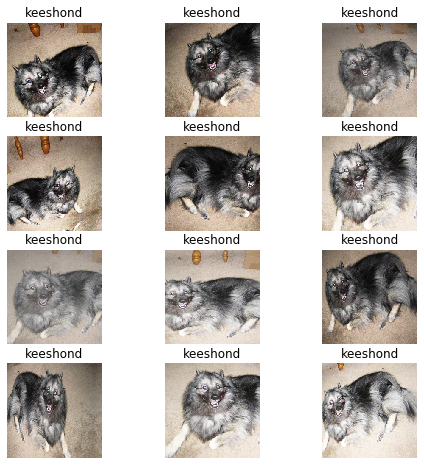

In [0]:
plot_multi(_plt,4,3,figsize=(8,8))

In [0]:
gc.collect()

31805

In [0]:
learn=cnn_learner(data,models.resnet34,metrics=error_rate,bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 27.7MB/s]


In [0]:
learn.fit_one_cycle(3,slice(1e-2),pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.618582,0.366174,0.095399,01:22
1,0.956957,0.290700,0.085250,01:21
2,0.714201,0.253398,0.074425,01:20


In [0]:
learn.unfreeze()
learn.fit_one_cycle(3,slice(1e-6,1e-3),pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.495352,0.238630,0.066306,01:25
1,0.464414,0.234120,0.063599,01:23
2,0.451406,0.231765,0.061570,01:22


In [0]:
learn.save('352')

In [0]:
data=get_data(352,16)

In [0]:
learn=cnn_learner(data,models.resnet34,metrics=error_rate,bn_final=True).load('352')

Category boxer

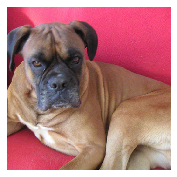

In [0]:
idx=11
x,y=data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
k=tensor([[1.,-5/3,1],
         [-5/3,-5/3,1],
         [1.,1,1],]).expand(1,3,3,3)/6

In [0]:
k

tensor([[[[ 0.1667, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.1667, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.1667, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [0]:
t=data.valid_ds[11][0].data; t.shape

torch.Size([3, 352, 352])

In [0]:
t[None].shape

torch.Size([1, 3, 352, 352])

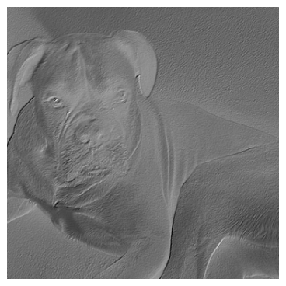

In [0]:
edge=F.conv2d(t[None],k)
show_image(edge[0],figsize=(5,5))

In [0]:
edge.shape

torch.Size([1, 1, 350, 350])

In [0]:
m=learn.model.eval()

In [0]:
xb,_=data.one_item(x)
xb_im=Image(data.denorm(xb)[0])
xb=xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
  with hook_output(m[0]) as hook_a:
    with hook_output(m[0],grad=True) as hook_g:
      preds=m(xb)
      preds[0,int(cat)].backward()
  return hook_a,hook_g

In [0]:
hook_a,hook_g=hooked_backward()

In [0]:
acts=hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [0]:
avg_act=acts.mean(0)
avg_act.shape

torch.Size([11, 11])

In [0]:
def show_hm (hm):
  _,ax=plt.subplots()
  xb_im.show(ax)
  ax.imshow(hm,alpha=0.5,extent=(0,352,352,0),interpolation='bilinear',cmap='magma')

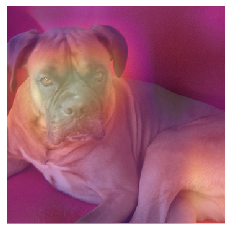

In [0]:
show_hm(avg_act)